In [226]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import pymc_bart as pmb
import matplotlib.pyplot as plt
import seaborn as sns

# Modelando la superficie de respuesta con pymc-bart


In [227]:
X = pd.read_csv("data/X.csv")
zy = pd.read_csv(
    "data/zy_2.csv"
)  # uso la condicion 2 de las 20 condiciones del concurso. Ground truths en zymu_1.csv

z = zy["z"].values  # tratamiento asignado
y = zy["y"].values  # observaciones

num_covariates = X.shape[1]
num_individuals = X.shape[0]
print(f"Número de covariables: {num_covariates}")
print(f"Número de individuos: {num_individuals}")

Número de covariables: 58
Número de individuos: 4802


In [228]:
X.dtypes

x_1       int64
x_2      object
x_3     float64
x_4     float64
x_5       int64
x_6       int64
x_7       int64
x_8       int64
x_9       int64
x_10      int64
x_11      int64
x_12      int64
x_13      int64
x_14      int64
x_15      int64
x_16      int64
x_17      int64
x_18      int64
x_19      int64
x_20      int64
x_21     object
x_22      int64
x_23      int64
x_24     object
x_25      int64
x_26      int64
x_27      int64
x_28      int64
x_29      int64
x_30      int64
x_31      int64
x_32      int64
x_33      int64
x_34      int64
x_35      int64
x_36      int64
x_37      int64
x_38      int64
x_39      int64
x_40      int64
x_41      int64
x_42      int64
x_43      int64
x_44      int64
x_45      int64
x_46      int64
x_47      int64
x_48      int64
x_49      int64
x_50      int64
x_51      int64
x_52      int64
x_53      int64
x_54      int64
x_55      int64
x_56      int64
x_57      int64
x_58      int64
dtype: object

Preprocesamiento:

- one-hot encoding de las variables categoricas
- castear valores numericos a float32


In [229]:
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58
0,29,C,1.0,7.0,60,85,0,0,1,0,...,0,0,0,0,0,0,0,0,45,39
1,27,C,0.0,0.0,64,178,0,0,0,0,...,0,0,0,0,0,0,0,0,46,42
2,27,C,0.0,0.0,60,102,0,0,0,0,...,1,0,0,0,0,0,0,0,45,40
3,37,C,0.0,0.0,65,174,0,0,0,0,...,0,0,0,0,0,0,0,0,47,40
4,24,C,20.0,14.0,63,129,0,0,0,0,...,2,0,0,0,0,0,0,0,47,43


In [230]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
categorical_cols

['x_2', 'x_21', 'x_24']

In [231]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded = X_encoded.astype("float32")
X_encoded.head()

,x_1,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,...,x_21_K,x_21_L,x_21_M,x_21_N,x_21_O,x_21_P,x_24_B,x_24_C,x_24_D,x_24_E
0,29.0,1.0,7.0,60.0,85.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,27.0,0.0,0.0,64.0,178.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,27.0,0.0,0.0,60.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37.0,0.0,0.0,65.0,174.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24.0,20.0,14.0,63.0,129.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modelando la superficie de respuesta:

$$Y_i = f(X_i, Z_i) + \epsilon_i$$

La respuesta $Y_i$ depende una superficie de respuesta desconocida $f$ de las variables $X_i$ y $Z_i$ y un error aleatorio $\epsilon_i$. La superficie de respuesta es modelada con BART.

En principio no tenemos mucha informacion, asumimos que $\epsilon_i$ tiene distribucion normal con media cero y desvio estandard $\sigma$ con una distribucion HalfNormal ancha.


In [335]:
with pm.Model() as model1:
    # covariables + Z
    X_combined = pm.Data("X_combined", X_encoded.assign(treatment=z))

    # Define BART model
    mu = pmb.BART("mu", X_combined, Y=y, m = 200)

    # Likelihood
    sigma = pm.InverseGamma("sigma", alpha=1, beta=2)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

model1

   mu ~ BART(<shared>, <constant>, 200, 0.95, 2)
sigma ~ InverseGamma(1, 2)
y_obs ~ Normal(mu, sigma)

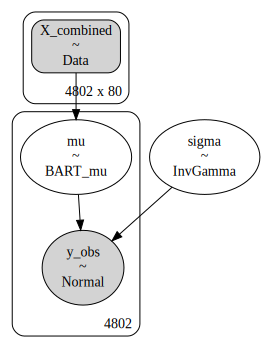

In [336]:
pm.model_to_graphviz(model1)

In [337]:
with model1:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


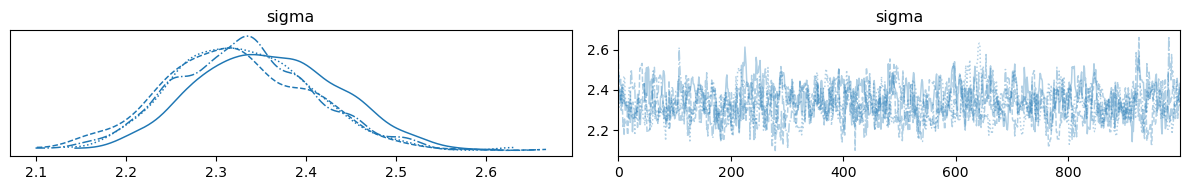

In [338]:
az.plot_trace(trace, var_names=["sigma"])
plt.tight_layout()

c:\Users\Damian\miniconda3\Lib\site-packages\arviz\plots\ecdfplot.py:298: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


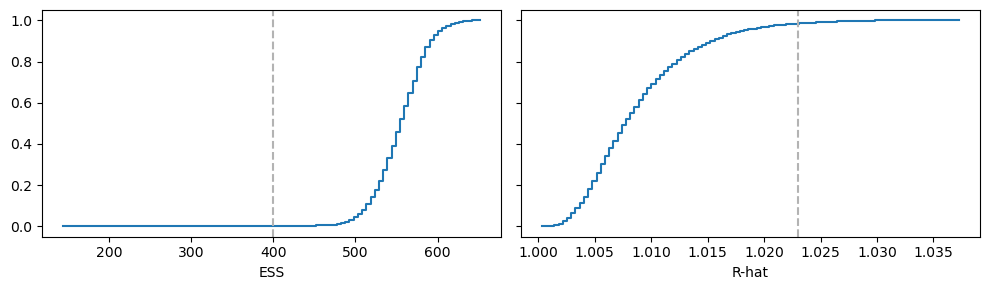

In [339]:
pmb.plot_convergence(trace, var_name="mu")
plt.tight_layout()

In [340]:
# Sampleo posterior predictivo, para predecir la media de las respuestas (la observada y la contrafactual)
# Sampleo ambos Z=1 y Z=0 en diferentes variables. Asigno Z=1 a tratamiento y Z=0 a control.

with model1:

    X_treated = pm.set_data({"X_combined": X_encoded.assign(treatment=1.0)})
    mu_treated = pm.sample_posterior_predictive(trace, var_names=["mu"])

    X_control = pm.set_data({"X_combined": X_encoded.assign(treatment=0.0)})
    mu_control = pm.sample_posterior_predictive(trace, var_names=["mu"])

Sampling: [mu]


Output()

Sampling: [mu]


Output()

In [341]:
pp_treated = az.extract(mu_treated.posterior_predictive)
pp_control = az.extract(mu_control.posterior_predictive)

In [342]:
ground_truth = pd.read_csv("acic_challenge_2016/zymu_1.csv")
ground_truth.head()

,z,y0,y1,mu0,mu1
0,0,3.157727,7.441336,3.890563,5.716108
1,0,4.281244,8.937312,5.870844,8.913574
2,0,7.621447,8.919930,7.006040,10.022676
3,1,-1.828240,4.015639,-1.046089,2.952779
4,0,-0.240268,5.296278,-0.478072,6.246069


### Individual Trearment Effect (ITE)


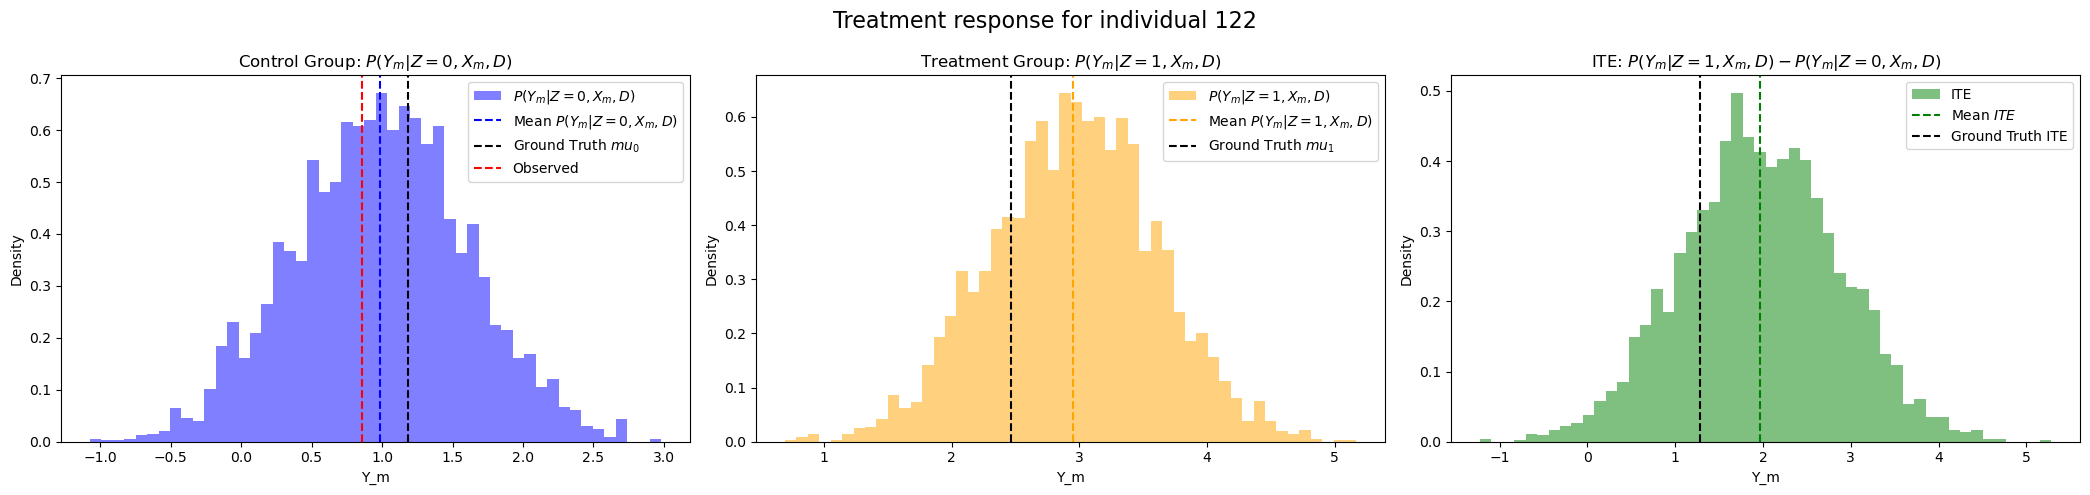

In [352]:
m = 122


fig, axs = plt.subplots(1, 3, figsize=(21, 5))

# ax0, P(Y_m|Z=0, X_m)
axs[0].set_title(f"Control Group: $P(Y_m|Z=0, X_m, D)$")
axs[0].hist(
    pp_control["mu"].values[m, :],
    bins=50,
    density=True,
    color="blue",
    alpha=0.5,
    label="$P(Y_m|Z=0, X_m, D)$",
)
axs[0].axvline(
    np.mean(pp_control["mu"].values[m, :]),
    color="Blue",
    linestyle="--",
    alpha=1,
    label="Mean $P(Y_m|Z=0, X_m, D)$",
)
axs[0].axvline(
    ground_truth["mu0"][m],
    color="BLACK",
    linestyle="--",
    alpha=1,
    label="Ground Truth $mu_0$",
)

if z[m] == 0:
    axs[0].axvline(y[m], color="red", linestyle="--", label="Observed")

# ax1, P(Y_m|Z=1, X_m)
axs[1].set_title(f"Treatment Group: $P(Y_m|Z=1, X_m, D)$")
axs[1].hist(
    pp_treated["mu"].values[m, :],
    bins=50,
    density=True,
    color="orange",
    alpha=0.5,
    label="$P(Y_m|Z=1, X_m, D)$",
)
axs[1].axvline(
    np.mean(pp_treated["mu"].values[m, :]),
    color="orange",
    linestyle="--",
    alpha=1,
    label="Mean $P(Y_m|Z=1, X_m, D)$",
)
axs[1].axvline(
    ground_truth["mu1"][m],
    color="BLACK",
    linestyle="--",
    alpha=1,
    label="Ground Truth $mu_1$",
)

if z[m] == 1:
    axs[1].axvline(y[m], color="red", linestyle="--", label="Observed")

# ax2, ITE = P(Y_m|Z=1, X_m) - P(Y_m|Z=0, X_m)
axs[2].set_title(f"ITE: $P(Y_m|Z=1, X_m, D) - P(Y_m|Z=0, X_m, D)$")
axs[2].hist(
    pp_treated["mu"].values[m, :] - pp_control["mu"].values[m, :],
    bins=50,
    density=True,
    color="green",
    alpha=0.5,
    label="ITE",
)
axs[2].axvline(
    np.mean(pp_treated["mu"].values[m, :] - pp_control["mu"].values[m, :]),
    color="green",
    linestyle="--",
    alpha=1,
    label="Mean $ITE$",
)
axs[2].axvline(
    ground_truth["mu1"][m] - ground_truth["mu0"][m],
    color="BLACK",
    linestyle="--",
    alpha=1,
    label="Ground Truth ITE",
)


for ax in axs:
    ax.legend()
    ax.set_xlabel("Y_m")
    ax.set_ylabel("Density")

plt.suptitle(f"Treatment response for individual {m}", fontsize=16)

plt.tight_layout()

### Sample Average Treatment Effect (SATE)


In [344]:
pp_sate = (pp_treated - pp_control).mean(dim="mu_dim_0")

sate_samples = pp_sate["mu"].values

In [345]:
ground_truth_sate = (ground_truth["y1"] - ground_truth["y0"]).mean()

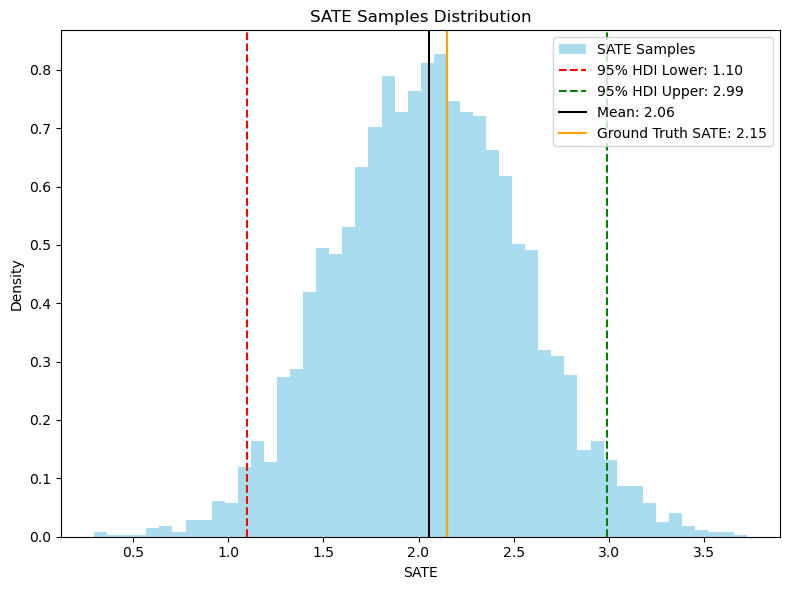

In [346]:
hdi_bounds = az.hdi(sate_samples, hdi_prob=0.95)

plt.figure(figsize=(8, 6))
plt.hist(
    sate_samples,
    bins=50,
    density=True,
    alpha=0.7,
    color="skyblue",
    label="SATE Samples",
)
plt.axvline(
    hdi_bounds[0],
    color="red",
    linestyle="--",
    label=f"95% HDI Lower: {hdi_bounds[0]:.2f}",
)
plt.axvline(
    hdi_bounds[1],
    color="green",
    linestyle="--",
    label=f"95% HDI Upper: {hdi_bounds[1]:.2f}",
)
plt.axvline(
    sate_samples.mean(),
    color="black",
    linestyle="-",
    label=f"Mean: {sate_samples.mean():.2f}",
)

plt.axvline(
    ground_truth_sate,
    color="orange",
    linestyle="-",
    label=f"Ground Truth SATE: {ground_truth_sate:.2f}",
)

plt.title("SATE Samples Distribution")
plt.xlabel("SATE")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### Average Treatment effect on the Treated (ATT)


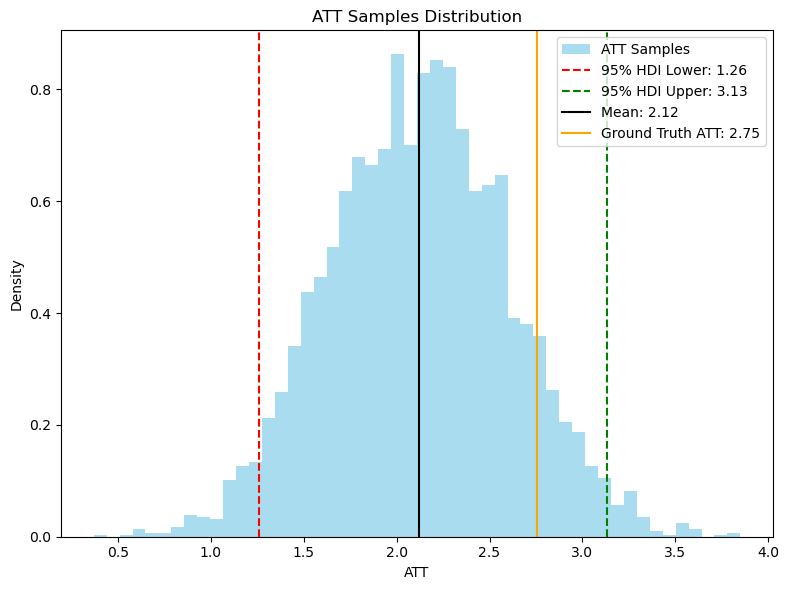

In [347]:
# Filtrar los individuos tratados (Z = 1)
treated_indices = np.where(z == 1)[0]

# Extraer las muestras de mu para los tratados
pp_att = pp_treated["mu"].values[treated_indices, :] - pp_control["mu"].values[treated_indices, :]

# Calcular el ATT promedio
att_samples = pp_att.mean(axis=0)

# Calcular el ATT ground truth
ground_truth_att = (ground_truth.loc[treated_indices, "y1"] - ground_truth.loc[treated_indices, "y0"]).mean()

# Visualizar la distribución de las muestras de ATT
hdi_bounds_att = az.hdi(att_samples, hdi_prob=0.95)

plt.figure(figsize=(8, 6))
plt.hist(
    att_samples,
    bins=50,
    density=True,
    alpha=0.7,
    color="skyblue",
    label="ATT Samples",
)
plt.axvline(
    hdi_bounds_att[0],
    color="red",
    linestyle="--",
    label=f"95% HDI Lower: {hdi_bounds_att[0]:.2f}",
)
plt.axvline(
    hdi_bounds_att[1],
    color="green",
    linestyle="--",
    label=f"95% HDI Upper: {hdi_bounds_att[1]:.2f}",
)
plt.axvline(
    att_samples.mean(),
    color="black",
    linestyle="-",
    label=f"Mean: {att_samples.mean():.2f}",
)

plt.axvline(
    ground_truth_att,
    color="orange",
    linestyle="-",
    label=f"Ground Truth ATT: {ground_truth_att:.2f}",
)

plt.title("ATT Samples Distribution")
plt.xlabel("ATT")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### Feature Importance

In [358]:
vi = pmb.compute_variable_importance(trace, mu, X_encoded.assign(treatment=1))

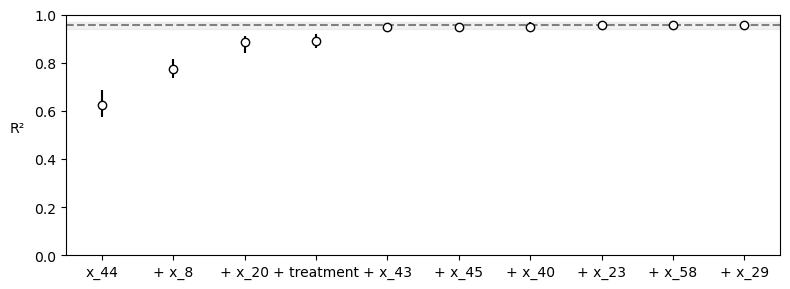

In [364]:
pmb.plot_variable_importance(vi, submodels=np.arange(0, 10))
plt.tight_layout()